# Proyecto Final - Vision Artificial
## Carrito Duckitown

el proyecto consta de 2 convolutional layers que se usaran para la direccion del carrito y la deteccion de senales de transito 

- Jose Ernesto Linares Chavez
- Mauricio Lopez Garcia
- Andres Ayala

# CNN para las direcciones del carrito 
## Imports

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as f
from torchvision import datasets, transforms, models
import cv2
from collections import OrderedDict
import numpy as np
import statistics
import os
from PIL import Image
import random

In [3]:
# Verificar si CUDA está disponible
if torch.cuda.is_available():
    
    # Obtener el número de dispositivos GPU disponibles
    device_count = torch.cuda.device_count()
    print(f"Se encontraron {device_count} dispositivos GPU CUDA.")

    # Obtener información detallada sobre cada dispositivo GPU
    for i in range(device_count):
        device = torch.cuda.get_device_name(i)
        print(f"Dispositivo GPU {i}: {device}")
else:
    print("CUDA no está disponible en este sistema.")

Se encontraron 1 dispositivos GPU CUDA.
Dispositivo GPU 0: NVIDIA GeForce RTX 2070 with Max-Q Design


# DATASET

El dataset consta de 2 clases, adelante e izquierda, estos se dividen en sus carpetas de train y test, por ahora no tenemos validacion

(3000, 4000, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

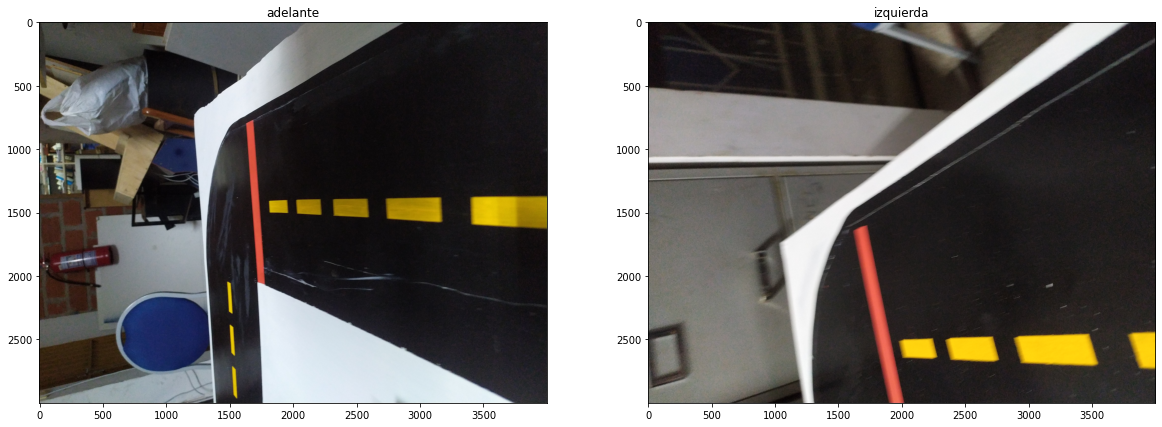

In [2]:
data_training = 'Dataset/train'
data_test = 'Dataset/test'

#guarda en una lista los nombres de las clases 
class_names = os.listdir(data_training)

fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes = axes.ravel()

for i in range(len(class_names)):
    
    subfolder_name = class_names[i]

    training_path = os.path.join(data_training, subfolder_name)
    file_names = os.listdir(training_path)
    rand = random.randint(0, len(file_names))

    image_path = os.path.join(training_path, file_names[rand])
    img = plt.imread(image_path)
    axes[i].imshow(img)
    axes[i].set_title(f"{class_names[i]}")
    
print(img.shape)    
plt.tight_layout
plt.show

In [3]:
count = 0
total_train = 0

for i in range(len(class_names)):
   subfolder_name = class_names[i]
   class_dir =  os.path.join(data_training, subfolder_name)
   count = len(os.listdir(class_dir))
   total_train += count
   end = "\n"
   print(f"hay {count} imagenes de {class_names[i]}", end=end)

print(f"en total hay {total_train} imagenes en training")

hay 397 imagenes de adelante
hay 155 imagenes de izquierda
en total hay 552 imagenes en training


In [4]:
count = 0
total_test = 0

for i in range(len(class_names)):
   subfolder_name = class_names[i]
   class_dir =  os.path.join(data_test, subfolder_name)
   count = len(os.listdir(class_dir))
   total_test += count
   end = "\n"
   print(f"hay {count} imagenes de {class_names[i]}", end=end)

print(f"en total hay {total_test} imagenes en test")

hay 25 imagenes de adelante
hay 25 imagenes de izquierda
en total hay 50 imagenes en test


# Estandarizacion

El tamano de las imagenes tomadas es de 3000x4000x3, las imagenes tienen demasiada resolucion para poder hacer una CNN ligera.

In [18]:
import os
import cv2

def leer_imagenes_carpeta(carpeta):
    imagenes = []
    extensiones_permitidas = ['.jpg', '.jpeg', '.png']  # Puedes añadir más extensiones si es necesario

    for nombre_archivo in os.listdir(carpeta):
        extension = os.path.splitext(nombre_archivo)[1].lower()

        if extension in extensiones_permitidas:
            ruta_archivo = os.path.join(carpeta, nombre_archivo)
            imagen = cv2.imread(ruta_archivo)
            imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
            imagen = cv2.resize(imagen, (224, 224))
            
            if imagen is not None:
                imagenes.append(imagen)

    return imagenes
 

In [19]:
adelante_train = leer_imagenes_carpeta('dataset/train/adelante')
print(f"se cargaron {len(adelante_train)} elementos de train")

adelante_test = leer_imagenes_carpeta('dataset/test/adelante')
print(f"se cargaron {len(adelante_test)} elementos de train")

se cargaron 397 elementos de train
se cargaron 25 elementos de train


In [20]:
izquierda_train = leer_imagenes_carpeta('dataset/train/izquierda')
print(f"se cargaron {len(izquierda_train)} elementos de train")

izquierda_test = leer_imagenes_carpeta('dataset/test/izquierda')
print(f"se cargaron {len(izquierda_test)} elementos de train")

se cargaron 155 elementos de train
se cargaron 25 elementos de train


In [38]:
def mostrar_dataset(dataset, rows, columns):
    
    if len(dataset) < rows*columns:
        print("demasiadas columnas y filas para el dataset")
        
    else:
        fig, axes = plt.subplots(rows, columns, figsize=(20,10))
        axes = axes.ravel()
        for i in range(rows*columns):
            rand = random.randint(0, len(dataset)-1)
            img = dataset[rand]

            axes[i].imshow(img)
            axes[i].set_title("adelante")
            
        print(img.shape)    
        plt.tight_layout
        plt.show

(224, 224, 3)


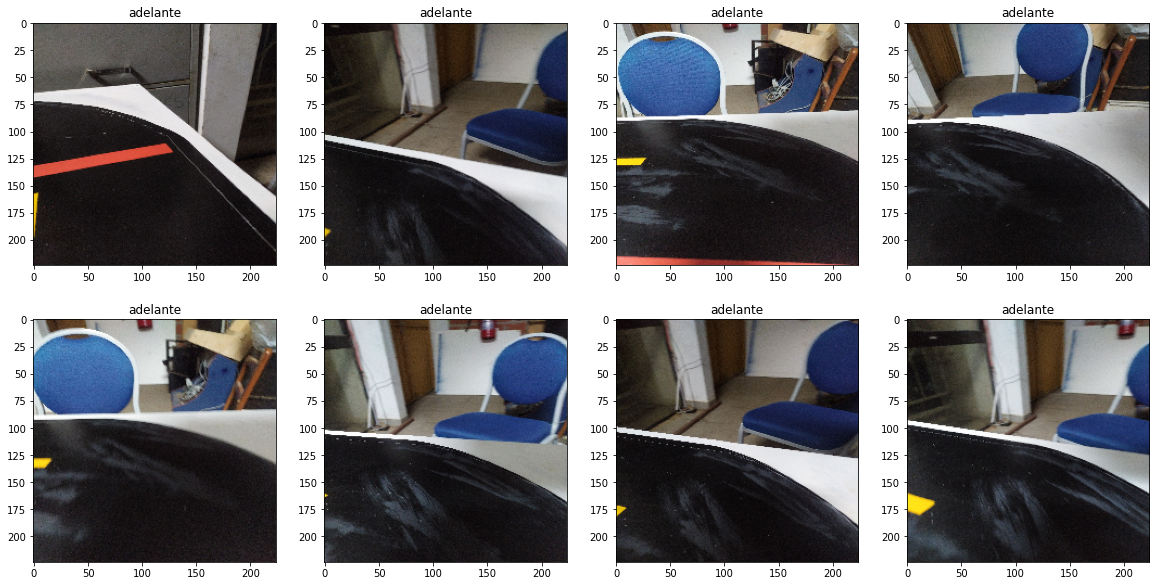

In [44]:
mostrar_dataset(izquierda_train, 2, 4)

(224, 224, 3)


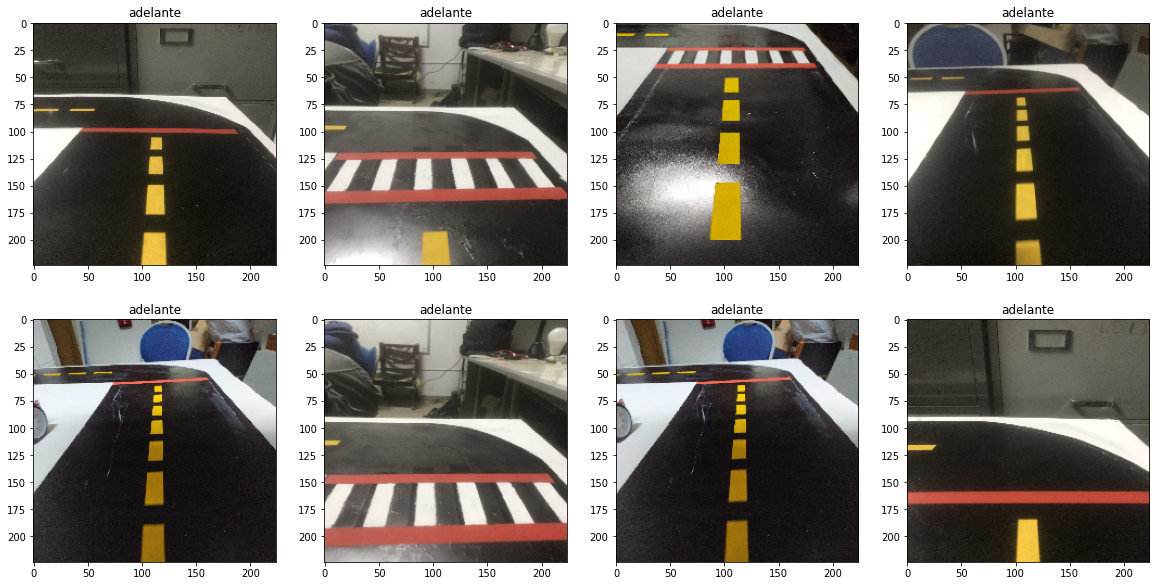

In [45]:
mostrar_dataset(adelante_train, 2, 4)

In [60]:
def guardar_dataset(dataset, path):   
    for i in range(len(dataset)):
        plt.imsave(f"{path}/img{i}.jpg", dataset[i])

In [63]:
guardar_dataset(adelante_train, "std_dataset/train/adelante")

In [64]:
guardar_dataset(izquierda_train, "std_dataset/train/izquierda")

In [164]:
data_dir = 'std_dataset'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5), (0.5))])


test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5), (0.5))])


train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=25, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=True)

In [66]:
print(type(trainloader))
dataset_iter = iter(trainloader)
images, labels = next(dataset_iter)
print(images.shape)

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([32, 3, 224, 224])


In [138]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        # Capas convolucionales
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        # Capas de pooling
        self.pool = nn.MaxPool2d(2, 2)
        # Capas totalmente conectadas
        self.fc1 = nn.Linear(64 * 26 * 26, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        # Convolucionales + Pooling
        x = self.pool(f.relu(self.conv1(x)))
        x = self.pool(f.relu(self.conv2(x)))
        x = self.pool(f.relu(self.conv3(x)))
        # Aplanar
        x = x.view(x.size(0), -1)
        # Capas totalmente conectadas
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = f.log_softmax(self.fc3(x), dim=1)
        return x

In [139]:
modelDeep = DeepCNN()
print(modelDeep)

DeepCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=43264, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


In [140]:
# Calculate accuracy before training
correct = 0
total = 0

# Iterate through test dataset
for images, labels in testloader:

    # forward pass to get outputs
    # the outputs are a series of class scores
    #print(images.shape)
    outputs = modelDeep(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
# to convert `correct` from a Tensor into a scalar, use .item()
accuracy = 100.0 * correct.item() / total

# print it out!
print('Accuracy before training: ', accuracy)

Accuracy before training:  48.0


In [141]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelDeep.parameters(), lr=0.001)

In [133]:
def graph_all(v, v_ac, v_loss, t, t_ac, t_loss):
    
    plt.figure("1")
    fig, ax = plt.subplots(2, 2, figsize=(18, 12))
    ax = ax.ravel()

    ax[0].set_title("Validation Accuracy")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("batch")
    ax[0].plot(v, v_ac)

    ax[1].set_title("val loss vs batches")
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("batch")
    ax[1].plot(v, v_loss)

    ax[2].set_title("train accuracy vs batches")
    ax[2].set_ylabel("Accuracy")
    ax[2].set_xlabel("batch")
    ax[2].plot(t, t_ac)

    ax[3].set_title("train loss vs batches")
    ax[3].set_ylabel("Loss")
    ax[3].set_xlabel("batch")
    ax[3].plot(t, t_loss)
    plt.show


In [134]:
def validationCNN(model, testloader, criterion):
    test_loss = 0
    accuracy = 0

    graphLoss = []
    graphAccuracy = []

    dev = torch.device("cuda:0")
    for images, labels in testloader:
        images, labels = images.to(dev), labels.to(dev)

        output = model(images)
        
        loss = criterion(output, labels)
        graphLoss.append(loss.to(torch.device("cpu")))

        test_loss += loss.item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])

        accur = equality.type(torch.FloatTensor).mean()

        graphAccuracy.append(accur.to(torch.device("cpu")))
        accuracy += accur

        
        
    return test_loss, accuracy, graphLoss, graphAccuracy

In [165]:
def train(n_epochs, modelx):

    if torch.cuda.is_available():
        dev = "cuda:0" 
    else: 
        dev = "cpu" 
        
    device = torch.device(dev) 
    modelx.to(device)
    
    vg_accur = []
    vg_loss = []
    vg = []
    x = 0

    tg_accur = []
    tg_loss = []
    tg = []
    steps = 0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        running_accur = 0.0

        for batch_i, data in enumerate(trainloader):
            tg.append(steps)
            steps += 1
            # get the input images and their corresponding labels
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            #print(inputs.shape)
            outputs = modelx(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)
            with torch.no_grad():
                tg_loss.append(loss.to(torch.device("cpu")))

            # backward pass to calculate the parameter gradients
            loss.backward()

            # Calcular la precisión de entrenamiento
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            total = labels.size(0)
            train_accuracy = correct / total
            running_accur += train_accuracy

            tg_accur.append(train_accuracy)

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()

            if batch_i % 5 == 4:    # print every 50 batches
                # Make sure network is in eval mode for inference
                modelx.eval()
                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    test_loss, accuracy, graphL, graphA = validationCNN(modelx, testloader, criterion)
                vg_loss.extend(graphL)
                vg_accur.extend(graphA)

                #rango de testloader/batch
                for i in range(int(50/10)):
                    vg.append(x)
                    x += 1
                avg_loss = running_loss/5
                avg_accur = running_accur/5
                print('Epoch: {}, Batch: {}, TrainLoss: {:.4f}, TrainAccuracy: {:.4f}, ValidationLoss: {:.4f}, ValidationAccuracy: {:.4f}'.format(epoch + 1,
                                                                                                                                      batch_i+1,
                                                                                                                                      avg_loss,
                                                                                                                                      avg_accur, 
                                                                                                                                      test_loss/len(testloader), 
                                                                                                                                      accuracy/len(testloader)))
                running_loss = 0.0
                running_accur = 0.0
                modelx.train

    return vg, vg_accur, vg_loss, tg, tg_accur, tg_loss

In [142]:
# define the number of epochs to train for
n_epochs = 12 # start small to see if your model works, initially

# call train and record the loss over time
vg, vg_accur, vg_loss, tg, tg_accur, tg_loss = train(n_epochs, modelDeep)

Epoch: 1, Batch: 5, TrainLoss: 0.6742, TrainAccuracy: 0.5520, ValidationLoss: 0.7609, ValidationAccuracy: 0.5000
Epoch: 1, Batch: 10, TrainLoss: 0.6232, TrainAccuracy: 0.6640, ValidationLoss: 0.6133, ValidationAccuracy: 0.5000
Epoch: 1, Batch: 15, TrainLoss: 0.4783, TrainAccuracy: 0.7280, ValidationLoss: 0.4648, ValidationAccuracy: 0.5600
Epoch: 1, Batch: 20, TrainLoss: 0.4049, TrainAccuracy: 0.8480, ValidationLoss: 0.2678, ValidationAccuracy: 1.0000
Epoch: 2, Batch: 5, TrainLoss: 0.3977, TrainAccuracy: 0.8080, ValidationLoss: 0.1147, ValidationAccuracy: 1.0000
Epoch: 2, Batch: 10, TrainLoss: 0.2518, TrainAccuracy: 0.8800, ValidationLoss: 0.1683, ValidationAccuracy: 0.9600
Epoch: 2, Batch: 15, TrainLoss: 0.4239, TrainAccuracy: 0.8960, ValidationLoss: 0.0389, ValidationAccuracy: 1.0000
Epoch: 2, Batch: 20, TrainLoss: 0.2633, TrainAccuracy: 0.8880, ValidationLoss: 0.1667, ValidationAccuracy: 0.9800
Epoch: 3, Batch: 5, TrainLoss: 0.3799, TrainAccuracy: 0.8560, ValidationLoss: 0.2836, Vali

<Figure size 432x288 with 0 Axes>

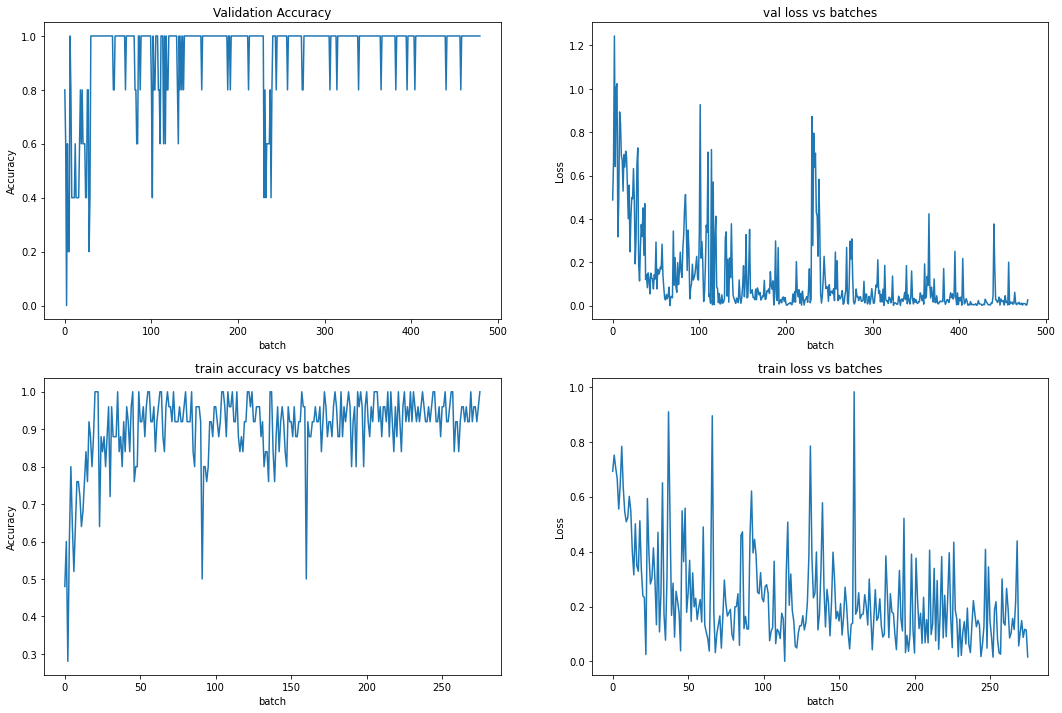

In [143]:
graph_all(vg, vg_accur, vg_loss, tg, tg_accur, tg_loss)


In [145]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

modelDeep.to(torch.device("cpu"))

# set the module to evaluation mode
modelDeep.eval()

for batch_i, data in enumerate(testloader):
    
    # get the input images and their corresponding labels
    inputs, labels = data


    # forward pass to get outputs
    outputs = modelDeep(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(5):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            class_names[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_names[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.007649

Test Accuracy of adelante: 100% (25/25)
Test Accuracy of izquierda: 100% (25/25)

Test Accuracy (Overall): 100% (50/50)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

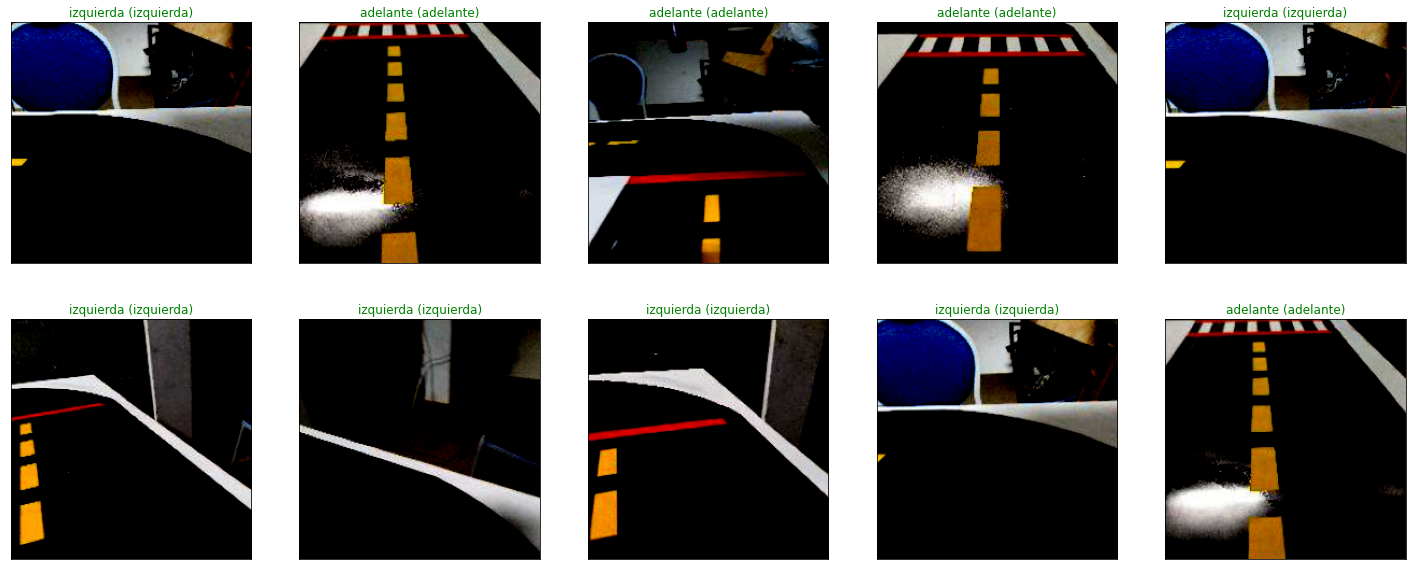

In [170]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)
# get predictions
preds = np.squeeze(modelDeep(images).data.max(1, keepdim=True)[1].numpy())
images = images.permute(0, 2, 3, 1)
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(10):
    ax = fig.add_subplot(2, int(5), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))